In [7]:
%run DensityPeakEstimation.ipynb

In [8]:
mat_data = scipy.io.loadmat('SalinasA.mat')
data = mat_data["salinasA"]
x, y, z = data.shape
salinasA = data.reshape((x*y, z))
norms = np.linalg.norm(salinasA, axis=1)
# Normalize each pixel vector by dividing by its norm
salinasA = salinasA / norms[:, np.newaxis]
mat_data_gt = scipy.io.loadmat('SalinasA_gt.mat')
gt = mat_data_gt["salinasA_gt"]
gt = gt.reshape(-1)

In [9]:
def land(X, K, GT, B, t):
    
    n = X.shape[0]
    Labels = np.zeros(n)
    
    Adj = make_adjacency(X, K)
    kernel = gaussian_kernel(Adj)
    diffusion = diffusion_map(kernel)
    diffusion = diffusion_map(kernel).astype(np.float16)  # 👈 cast to float32
    #print("diffusion dtype:", diffusion.dtype)
    
    Embed = embed(diffusion.astype(np.float16), t)  # ensure input is float32
    embedding = Embed[0].astype(np.float16)  # 👈 cast to float32
    #print("embedding dtype:", embedding.dtype)
    PWDiffDist = diffusion_dist(embedding)
    PWdist = cdist(X, X)
    Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist)
    centers = density_peaks_estimation(Delta_Density, B)
    
    total_c = []
    
    t = B
    it = 0
    while t > 0:
        
        while GT[centers[it]] == 0:
            it += 1
        
            #print(centers[it])
        Labels[centers[it]] = GT[centers[it]] + 1 
        #print(centers[it])
        total_c.append(centers[it])
        t-=1
        it += 1
    #print(np.where(Labels != 0))
    
    
    # Sort points by density
    siD = sorted(enumerate(Density_), key=lambda x: x[1], reverse=True)
    
    idx = np.array([int(index) for index, _ in siD])

    
    # Label highest density point if necessary
    
    if Labels[idx[0]] == 0:
        Labels[idx[0]] = GT[idx[0]] + 1
    
    
    # First pass
    row_max = np.max(diffusion, axis=1)

    for j in range(n):
        if Labels[idx[j]] == 0:
            NN = np.argmin(PWDiffDist[idx[j], idx[:j]])
            Labels[idx[j]] = Labels[idx[NN]]
    print(set(total_c))
    #print(len(set(total_c)))
    return Labels

In [10]:
def lend(X, K, GT, B, t, J, alpha):
    
    n = X.shape[0]
    #calculate relevant statistics
    Labels = np.zeros(n)
    Adj = make_adjacency(X, K)
    kernel = gaussian_kernel(Adj)
    diffusion = diffusion_map(kernel)
    Embed = embed(diffusion, t)
    embedding = Embed[0]
    PWdist = cdist(X, X)
    PWDiffDist = diffusion_dist(embedding)
    Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist)
    #begin LEND scheme as detailed in Algorithm 2 of paper
    total_c = []
    for iter in range(J):
        
        Labels = np.zeros(n)
       
        Embed = embed(diffusion, t)
        embedding = Embed[0]
        PWDiffDist = diffusion_dist(embedding)
        
        Delta_Density, Density_, Delta_ = find_density_peaks(X, K, PWdist, PWDiffDist, Density_)
        centers = density_peaks_estimation(Delta_Density, B - (2 - iter))
        
        t = B - ( (J-1) - iter)
        it = 0
        while t > 0:
            while GT[centers[it]] == 0:
                it += 1
            Labels[centers[it]] = GT[centers[it]] + 1 #+1 to ensure unlabeled points have value of 0
            #print(centers[it])
            total_c.append(centers[it])
            t-=1
            it += 1
        
        # Sort points by density
        siD = sorted(enumerate(Density_), key=lambda x: x[1], reverse=True)
        # Extracting just the indices and converting to NumPy array
        idx = np.array([int(index) for index, _ in siD])
        # Label highest density point if necessary
        if Labels[idx[0]] == 0:
            Labels[idx[0]] = GT[idx[0]] + 1
        # First pass
        row_max = np.max(diffusion, axis=1)
        for j in range(n):
            if Labels[idx[j]] == 0:
                NN = np.argmin(PWDiffDist[idx[j], idx[:j]])
                Labels[idx[j]] = Labels[idx[NN]]
        #weaken edges between points of differing class
        mask = np.where(np.equal.outer(Labels, Labels), 1, alpha)
        diffusion *= mask
        #renormalize
        row_sums = diffusion.sum(axis=1)
        diffusion = diffusion / row_sums[:, np.newaxis]

    '''
    Print query points and num points queried - note that due to the way we query you might end up querying more than
    budgeted. We discuss how to circumvent this in the paper, but instead you can just set a hard cut off in the querying procedure,
    i.e. stop when enough points have been queried.
    '''
    print(len(set(total_c)))
    print(set(total_c))
    return Labels
    

In [11]:
'''
Example usage:
Fill in with desired params, adjust for +1 in labeling, then calculate accuracy over nonzero labels.
'''
LAND = land(salinasA, 100, gt, 12, 30)

new knn
diffusion dtype: float16
seeded
embedding dtype: float16
(array([  26,  310,  396,  482, 1600, 1686, 2224, 2310, 3509, 3595, 3802,
       6081]),)
{1600, 6081, 482, 26, 2310, 3595, 396, 2224, 3509, 310, 1686, 3802}
12


In [12]:
'''
Artifact of code, set all labels back by one (because we needed to seperate unlabeled points in the algorithm and unlabeled points in the dataset
'''
LAND -=1

In [13]:
'''
eval only on points from the dataset that have a ground truth value
'''
mask = gt != 0
    # Calculate the difference only where the mask is True
difference = LAND[mask] != gt[mask]
    # Calculate the desired value
result = 1 - np.sum(difference) / np.sum(mask)

In [14]:
result

0.8818249813014211

In [15]:
'''
Example usage of LEND, returns all query points
'''
LEND = lend(salinasA, 100, gt, 12, 30, 3, .5)

new knn
seeded
seeded
seeded
seeded
12
{1600, 6081, 482, 26, 2310, 3595, 396, 2224, 3509, 310, 1686, 3802}


In [16]:
LEND -= 1

In [17]:
mask = gt != 0
    # Calculate the difference only where the mask is True
difference = LEND[mask] != gt[mask]
    # Calculate the desired value
result = 1 - np.sum(difference) / np.sum(mask)

In [18]:
result

0.9719521316379955

In [23]:
value_map = {0: 0, 1: 1, 10: 2, 11: 3, 12: 4, 13: 5, 14: 6}

# Create a vectorized function to apply the mapping
vectorized_map = np.vectorize(value_map.get)

# Apply the mapping to the matrix
mapped_matrix = vectorized_map(LAND.reshape(83, 86))
map_gt = vectorized_map(gt.reshape(83, 86))
map_lend = vectorized_map(LEND.reshape(83, 86))

Text(0.5, 1.0, 'SalinasA Ground Truth Data')

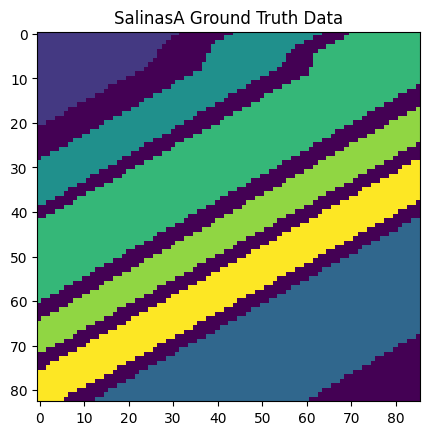

In [24]:
plt.imshow(map_gt)
plt.title("SalinasA Ground Truth Data")

Text(0.5, 1.0, 'LAND on SalinasA, Budget = 12')

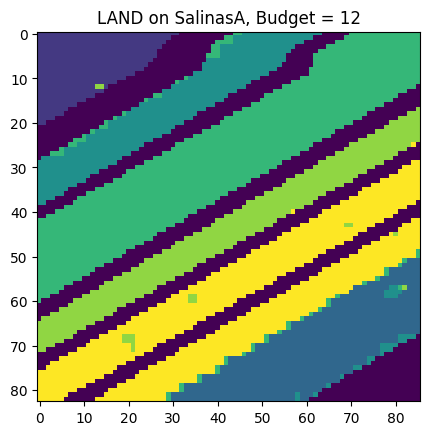

In [25]:
plt.imshow(mapped_matrix * mask.reshape(83, 86))
plt.title("LAND on SalinasA, Budget = 12")

Text(0.5, 1.0, 'LEND on SalinasA, Budget = 12')

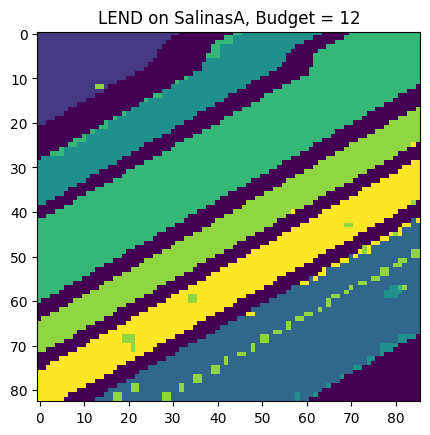

In [26]:
plt.imshow(map_lend*mask.reshape(83, 86))
plt.title("LEND on SalinasA, Budget = 12")